<a href="https://colab.research.google.com/github/potapov-dm/numbers_generation_cDCGAN/blob/main/cDCGAN_MNIST_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import importlib
if importlib.util.find_spec("imageio") is None:
    !pip install imageio
if importlib.util.find_spec("tensorflow_docs") is None:
    !pip install git+https://github.com/tensorflow/docs

In [ ]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal

import glob
import imageio
import tensorflow_docs.vis.embed as embed
from IPython import display

In [ ]:
def make_generator_model():
  noise = tf.keras.Input(shape=(NOISE_DIM,))
  label = tf.keras.Input(shape=(1,))

  label_embedding = layers.Embedding(NUM_OF_CLASSES, 100)(label)
  label_embedding = layers.Flatten()(label_embedding)

  input_concat = layers.Concatenate()([noise, label_embedding])

  dense = layers.Dense(7*7*128, use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_concat)
  dense = layers.BatchNormalization()(dense)
  dense = layers.LeakyReLU()(dense)

  reshaped = layers.Reshape((7, 7, 128))(dense)

  upsample1 = layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(reshaped)
  upsample1 = layers.BatchNormalization()(upsample1)
  upsample1 = layers.LeakyReLU()(upsample1)

  upsample2 = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(upsample1)
  upsample2 = layers.BatchNormalization()(upsample2)
  upsample2 = layers.LeakyReLU()(upsample2)

  output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(upsample2)

  model = tf.keras.Model(inputs=[noise, label], outputs=output)
  return model  #LeakyReLU

# g = make_generator_model()
# display(tf.keras.utils.plot_model(g, show_shapes=True))

In [ ]:
def make_discriminator_model():
    image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(NUM_OF_CLASSES, 50)(label_input)
    label_embedding = layers.Dense(IMG_SIZE*IMG_SIZE, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(label_embedding)
    label_embedding = layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(label_embedding)

    input_concat = layers.Concatenate(axis=-1)([image_input, label_embedding])

    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_concat)
    conv1 = layers.LeakyReLU()(conv1)
    conv1 = layers.Dropout(0.3)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.LeakyReLU()(conv2)
    conv2 = layers.Dropout(0.3)(conv2)

    flatten = layers.Flatten()(conv2)
    output = layers.Dense(1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(flatten)

    model = tf.keras.Model(inputs=[image_input, label_input], outputs=output)
    return model

In [ ]:
def dataset_init(img_size):
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

  def preprocess_image(image):
      image = tf.expand_dims(image, axis = 2)
      image = tf.image.resize(image, (img_size, img_size))
      image = (tf.cast(image, tf.float32) - 127.5) / 127.5
      return image

  def preprocess_label(label):
      return tf.cast(label, tf.int64)

  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), preprocess_label(y)))
  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return train_dataset

In [ ]:
def generate_and_save_images(model, epoch, image_input, label_input):
  predictions = model([image_input, label_input], training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
      plt.subplot(NUM_OF_CLASSES, len(label_input) // NUM_OF_CLASSES, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def discriminator_loss(real_output, fake_output):
  shape_real = tf.shape(real_output)
  random_tensor_ones = tf.random.uniform(shape_real, minval=0.85, maxval=1.05)
  smooth_ones = tf.ones_like(real_output) * random_tensor_ones

  shape_fake = tf.shape(fake_output)
  random_tensor_zeros = tf.random.uniform(shape_fake, minval=0, maxval=0.1)
  smooth_zeros = tf.zeros_like(fake_output) + random_tensor_zeros

  real_loss = cross_entropy(smooth_ones, real_output)
  fake_loss = cross_entropy(smooth_zeros, fake_output)

  return real_loss + fake_loss

def generator_loss(fake_output):
  shape_fake = tf.shape(fake_output)
  random_tensor = tf.random.uniform(shape_fake, minval=0.85, maxval=1.05)
  smooth_ones = tf.ones_like(fake_output) * random_tensor
  return cross_entropy(smooth_ones, fake_output)

# Train

In [ ]:
@tf.function
def train_step(image_batch, label_batch):
  noise_batch = tf.random.normal((len(label_batch), NOISE_DIM))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_batch = generator([noise_batch, label_batch], training=True)

    real_output = discriminator([image_batch, label_batch], training=True)
    fake_output = discriminator([generated_batch, label_batch], training=True)

    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start_time = time.time()
    if(epoch+1) == 55:
      generator_optimizer.learning_rate.assign(generator_optimizer.learning_rate / 10.0)
      discriminator_optimizer.learning_rate.assign(discriminator_optimizer.learning_rate / 10.0)
      print("\nlearning rate change!")

    for image_batch, label_batch in train_dataset:
      train_step(image_batch, label_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    print('[%d/%d] - time: %.2f' % ((epoch + 1), epochs, time.time() - start_time))
    generate_and_save_images(generator, epoch + 1, SEED, SEED_LABELS)

In [ ]:
IMG_SIZE = 28
NUM_OF_CLASSES = 10
BUFFER_SIZE = 60000
BATCH_SIZE = 128
NOISE_DIM = 100

train_dataset = dataset_init(IMG_SIZE)

SEED = tf.random.normal((NUM_OF_CLASSES*10, NOISE_DIM))
SEED_LABELS = tf.repeat(tf.range(NUM_OF_CLASSES), 10)

In [ ]:
LEARNING_RATE = 0.0002
EPOCHS = 60

[60/60] - time: 8.77


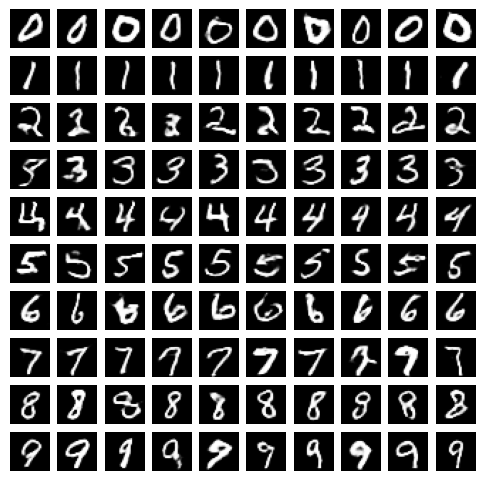

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

train(train_dataset, EPOCHS)


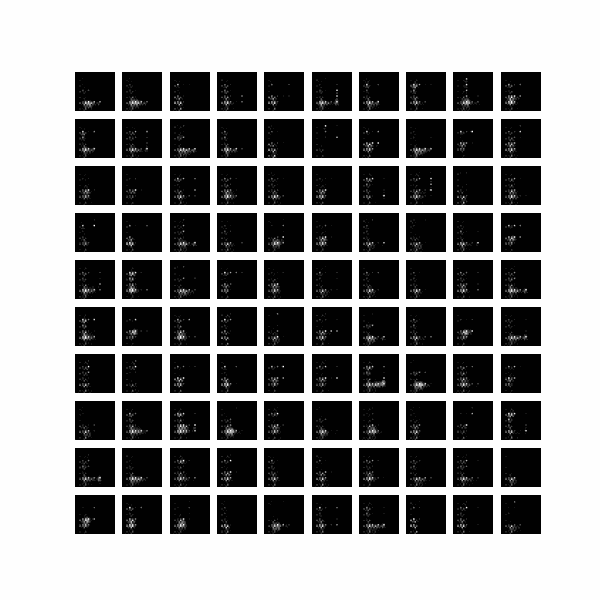

In [ ]:
anim_file = 'сDCGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
  image = imageio.v2.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)

In [2]:
# from google.colab import drive
# import os
# import shutil

# drive.mount('/content/drive')
# save_dir = "/content/drive/My Drive/cDCGAN_MNIST_TF/"
# file_count = 1
# while True:
#   gen_path = os.path.join(save_dir, f"generator_сDCGAN_{file_count}.h5")
#   disc_path = os.path.join(save_dir, f"discriminator_сDCGAN_{file_count}.h5")
#   gif_path = os.path.join(save_dir, f"сDCGAN_{file_count}.gif")

#   if os.path.exists(gen_path) or os.path.exists(disc_path) or os.path.exists(gif_path):
#     file_count += 1
#   else:
#     generator.save(gen_path)
#     discriminator.save(disc_path)
#     # shutil.copy(anim_file, save_dir)
#     break

# print(f'Saved as {gen_path}, {disc_path}, ')